# Smart Home Appliance Usage Forecasting
## 03 - Forecasting Model (Prophet)

This notebook builds a time series forecasting model for appliance usage using Facebook Prophet.

In [37]:
# Install Prophet if not already installed
# !pip install prophet
import os
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# For MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100

## Load Feature-Enhanced Data

In [38]:
df = pd.read_csv('../data/processed/iot_logs_features.csv', parse_dates=['timestamp'])
df.head()

,timestamp,appliance_id,appliance_name,usage,user_id,date,temp,temp_min,temp_max,precipitation,wind_speed,hour,dayofweek,is_weekend,month,usage_lag_1,usage_lag_4,usage_lag_96,usage_roll_mean_4,usage_roll_sum_96
0,2025-05-29 23:35:52.423050,1,Air Conditioner,0.874,101,2025-05-29,33.5,29.4,38.7,0.0,6.5,23,3,False,5,NaN,NaN,NaN,0.874,0.874
1,2025-05-29 23:35:52.423050,3,Refrigerator,0.079,104,2025-05-29,33.5,29.4,38.7,0.0,6.5,23,3,False,5,NaN,NaN,NaN,0.079,0.079
2,2025-05-29 23:35:52.423050,1,Air Conditioner,0.739,103,2025-05-29,33.5,29.4,38.7,0.0,6.5,23,3,False,5,NaN,NaN,NaN,0.739,0.739
3,2025-05-29 23:35:52.423050,3,Refrigerator,0.062,102,2025-05-29,33.5,29.4,38.7,0.0,6.5,23,3,False,5,NaN,NaN,NaN,0.062,0.062
4,2025-05-29 23:35:52.423050,1,Air Conditioner,0.775,105,2025-05-29,33.5,29.4,38.7,0.0,6.5,23,3,False,5,NaN,NaN,NaN,0.775,0.775


In [39]:
# Load weather data if not already merged in features
weather_path = '../data/external/weather_data.csv'
if os.path.exists(weather_path):
    weather = pd.read_csv(weather_path, parse_dates=['date'])
    if 'dt' in weather.columns:
        weather['date'] = pd.to_datetime(weather['dt']).dt.date
    elif 'timestamp' in weather.columns:
        weather['date'] = pd.to_datetime(weather['timestamp']).dt.date
    else:
        weather['date'] = pd.to_datetime(weather['date']).dt.date

    df['date'] = df['timestamp'].dt.date
    df = df.merge(weather, on='date', how='left')
    print("Weather data merged. Columns now:", df.columns)
else:
    print("No weather data found at", weather_path)

Weather data merged. Columns now: Index(['timestamp', 'appliance_id', 'appliance_name', 'usage', 'user_id',
       'date', 'temp_x', 'temp_min_x', 'temp_max_x', 'precipitation_x',
       'wind_speed_x', 'hour', 'dayofweek', 'is_weekend', 'month',
       'usage_lag_1', 'usage_lag_4', 'usage_lag_96', 'usage_roll_mean_4',
       'usage_roll_sum_96', 'temp_y', 'temp_min_y', 'temp_max_y',
       'precipitation_y', 'wind_speed_y'],
      dtype='object')


## Select Appliance and Prepare Data for Prophet

We will forecast usage for a single appliance (e.g., Air Conditioner, user 101).

In [40]:
# Choose appliance and user
appliance = 'Air Conditioner'
user_id = 101

# Filter and aggregate to daily usage
df_appliance = df[(df['appliance_name'] == appliance) & (df['user_id'] == user_id)]
df_daily = df_appliance.resample('D', on='timestamp').usage.sum().reset_index()

# Prophet expects columns: ds (date), y (value)
df_daily = df_daily.rename(columns={'timestamp': 'ds', 'usage': 'y'})
df_daily.head()

,ds,y
0,2025-05-29,1.653
1,2025-05-30,38.041
2,2025-05-31,27.552
3,2025-06-01,27.274
4,2025-06-02,39.886


In [41]:
# Example: Add temperature as a regressor if available
if 'temp' in df_daily.columns:
    regressor_cols = ['temp']  # Add more weather features if available
else:
    regressor_cols = []

# Prophet expects regressors to be added explicitly

## Train/Test Split

In [42]:
# Use last 7 days for testing, rest for training
train = df_daily.iloc[:-7]
test = df_daily.iloc[-7:]
print(f"Train: {train.shape}, Test: {test.shape}")

Train: (24, 2), Test: (7, 2)


## Train Prophet Model and Forecast

In [43]:
m = Prophet(daily_seasonality=True, yearly_seasonality=False, weekly_seasonality=True)
for reg in regressor_cols:
    m.add_regressor(reg)
m.fit(train)

future = m.make_future_dataframe(periods=7)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

23:36:33 - cmdstanpy - INFO - Chain [1] start processing
23:36:33 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
21,2025-06-19,33.785932,26.500779,41.438107
22,2025-06-20,42.995473,35.050757,51.728641
23,2025-06-21,31.311639,23.585048,38.689538
24,2025-06-22,32.953070,24.534279,41.091508
25,2025-06-23,44.586371,36.379715,52.325423
26,2025-06-24,44.453325,36.395514,52.470266
27,2025-06-25,44.226295,36.653840,51.587062
28,2025-06-26,36.383372,28.087060,44.191966
29,2025-06-27,45.592913,37.868105,53.182317
30,2025-06-28,33.909080,26.089997,42.237067


## Visualize Forecast vs. Actuals

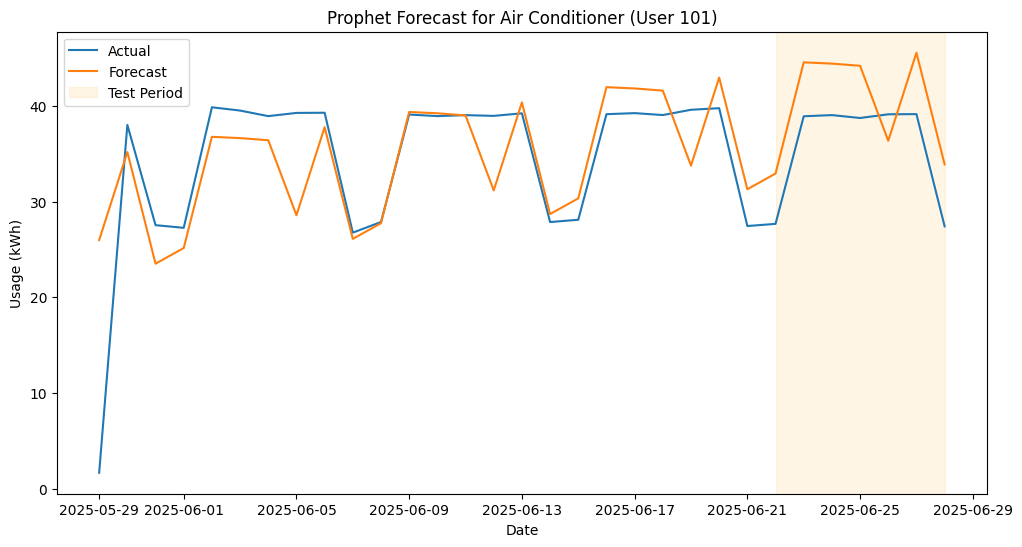

In [44]:
plt.figure(figsize=(12,6))
plt.plot(df_daily['ds'], df_daily['y'], label='Actual')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast')
plt.axvspan(test['ds'].min(), test['ds'].max(), color='orange', alpha=0.1, label='Test Period')
plt.legend()
plt.title(f'Prophet Forecast for {appliance} (User {user_id})')
plt.xlabel('Date')
plt.ylabel('Usage (kWh)')
plt.show()

## Model Evaluation (MAE, RMSE, MAPE) on Test Set

In [45]:
# Merge test and forecast
test_eval = test.merge(forecast[['ds', 'yhat']], on='ds', how='left')
mae = mean_absolute_error(test_eval['y'], test_eval['yhat'])
rmse = mean_squared_error(test_eval['y'], test_eval['yhat'], squared=False)
mape = mean_absolute_percentage_error(test_eval['y'], test_eval['yhat'])

print(f'MAE: {mae:.3f}')
print(f'RMSE: {rmse:.3f}')
print(f'MAPE: {mape:.2f}%')

MAE: 5.347
RMSE: 5.469
MAPE: 15.50%


C:\Users\turep\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Prophet Components Plot (Trend, Weekly Seasonality)

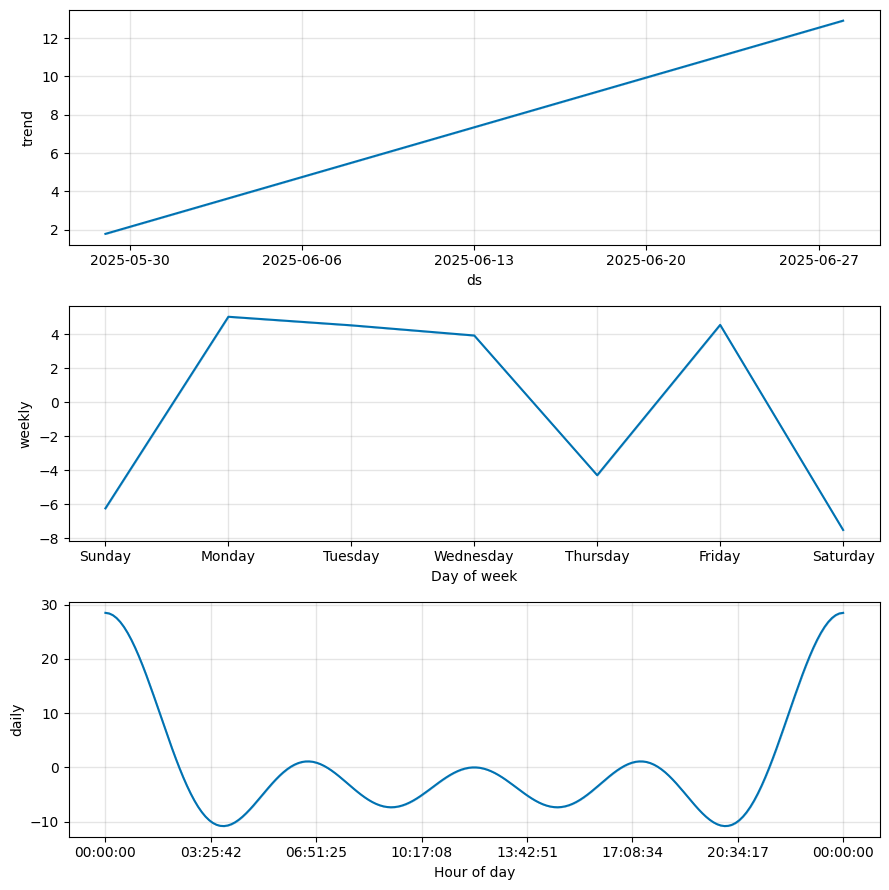

In [46]:
m.plot_components(forecast)
plt.show()

In [47]:
     m = Prophet(daily_seasonality=True, yearly_seasonality=False, weekly_seasonality=True)
     m.fit(train)
     future = m.make_future_dataframe(periods=7)
     forecast = m.predict(future)

23:36:34 - cmdstanpy - INFO - Chain [1] start processing
23:36:34 - cmdstanpy - INFO - Chain [1] done processing


In [48]:
import os
os.makedirs('forecast', exist_ok=True)
# Save Prophet forecast
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv('forecast/prophet_forecast.csv', index=False)
# Save evaluation metrics
with open('forecast/metrics.txt', 'w') as f:
    f.write(f'MAE: {mae:.3f}\n')
    f.write(f'RMSE: {rmse:.3f}\n')
    f.write(f'MAPE: {mape:.2f}%\n')